In [1]:
import sys
sys.path.append('../')

import numpy as np
import pygme

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

## Reproduce Fig. 1(b) in Cerjan and Fan, PRA (2017)

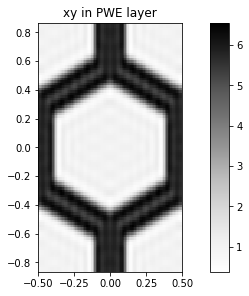

In [2]:
# Initialize a lattice
lattice = pygme.Lattice('hexagonal')
# Initialize a layer
layer = pygme.Layer(lattice, eps_b = 2.4**2)
# Add a shape to this layer 
l = 1/np.sqrt(3) # l-parameter in his paper in units of lattice constant a (which is a = 1 in my case)
hexagon = pygme.Hexagon(eps = 1, a = (1-0.1818*l)/2)
hexagon.rotate(np.pi/6)
layer.add_shape(hexagon)

# Initialize the PWE 
pwe = pygme.PlaneWaveExp(layer, gmax=5)
pwe.plot_overview_ft()

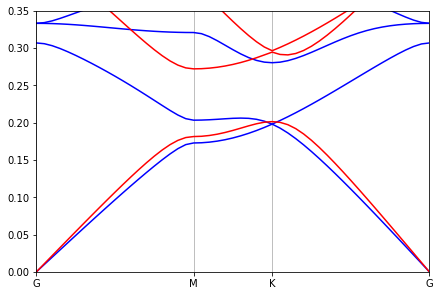

In [3]:
path = layer.lattice.bz_path(['G', 'M', 'K', 'G'], [20, 10, 20])

# Now we can run the PWE for both polarizations
pwe.run(kpoints=path.kpoints, pol='te')
freqs_te = pwe.freqs
pwe.run(kpoints=path.kpoints, pol='tm')
freqs_tm = pwe.freqs

# And plot the results!
fig, ax = plt.subplots(1, constrained_layout=True)
plt.plot(freqs_tm*l, 'b')
plt.plot(freqs_te*l, 'r')
ax.set_ylim([0, 0.35])
ax.set_xlim([0, pwe.freqs.shape[0]-1])
plt.xticks(path.pt_inds, path.pt_labels)
ax.xaxis.grid('True')
plt.show()

## Optimize the band gap with a supercell and autograd

In [4]:
import autograd.numpy as npa
from autograd import grad
pygme.set_backend('autograd')

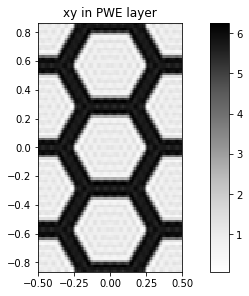

In [5]:
def pwe_cerjan(params, gmax=10):
    # Make a PWE simulation with 3 holes in the elementary cell
    # Initialize a lattice
    lattice = pygme.Lattice('hexagonal')
    # Initialize a layer
    layer = pygme.Layer(lattice, eps_b = 2.4**2)
    a_sc = np.sqrt(3)
    hex1 = pygme.Hexagon(eps=1, a = params[0]/a_sc)
    hex2 = pygme.Hexagon(eps=1, x_cent=np.sqrt(3)/2/a_sc, y_cent=0.5/a_sc, a=params[1]/a_sc)
    hex3 = pygme.Hexagon(eps=1, x_cent=np.sqrt(3)/2/a_sc, y_cent=-0.5/a_sc, a=params[2]/a_sc)
    # Make a supercell
    layer.add_shape(hex1, hex2, hex3)
    
    return pygme.PlaneWaveExp(layer, gmax=gmax)

# Initialize the PWE that should match the simulation above
l = 1/np.sqrt(3)
params = np.ones(3)*(1-0.1818*l)/2
pwe = pwe_cerjan(params)
pwe.plot_overview_ft()

## Reproduce Fig. 1(d) in Cerjan and Fan, PRA (2017)

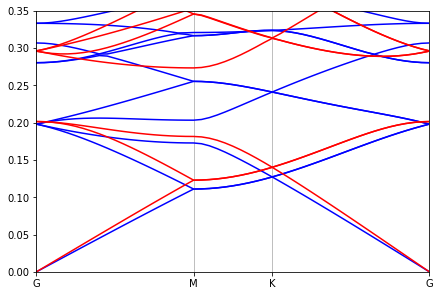

In [6]:
path = layer.lattice.bz_path(['G', 'M', 'K', 'G'], [20, 10, 20])

# Now we can run the PWE for both polarizations
pwe.run(kpoints=path.kpoints, pol='te')
freqs_te = pwe.freqs
pwe.run(kpoints=path.kpoints, pol='tm')
freqs_tm = pwe.freqs

# And plot the results!
fig, ax = plt.subplots(1, constrained_layout=True)
plt.plot(freqs_tm/3, 'b')
plt.plot(freqs_te/3, 'r')
ax.set_ylim([0, 0.35])
ax.set_xlim([0, pwe.freqs.shape[0]-1])
plt.xticks(path.pt_inds, path.pt_labels)
ax.xaxis.grid('True')
plt.show()

## Reproduce something like Fig. 1(f) in Cerjan and Fan, PRA (2017)

[0.42 0.53 0.53]


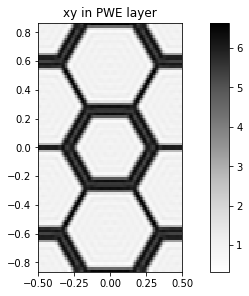

In [7]:
params = np.array([0.42, 0.53, 0.53])
print(params)
pwe = pwe_cerjan(params)
pwe.plot_overview_ft()

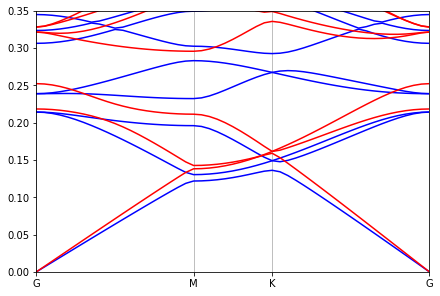

In [8]:
path = layer.lattice.bz_path(['G', 'M', 'K', 'G'], [20, 10, 20])

# Now we can run the PWE for both polarizations
pwe.run(kpoints=path.kpoints, pol='te')
freqs_te = pwe.freqs
pwe.run(kpoints=path.kpoints, pol='tm')
freqs_tm = pwe.freqs

# And plot the results!
fig, ax = plt.subplots(1, constrained_layout=True)
plt.plot(freqs_tm/3, 'b')
plt.plot(freqs_te/3, 'r')
ax.set_ylim([0, 0.35])
ax.set_xlim([0, pwe.freqs.shape[0]-1])
plt.xticks(path.pt_inds, path.pt_labels)
ax.xaxis.grid('True')
plt.show()

In [81]:
# Function to return the band-gap size around a given center frequency
def bg_size(freqs_te, freqs_tm, freq_cent = 0.29*3):
    freqs_all = npa.hstack((freqs_te.flatten(), freqs_tm.flatten()))
    freq_min = npa.amax(npa.where(freqs_all < freq_cent, freqs_all, 0))
    freq_max = npa.amin(npa.where(freqs_all > freq_cent, freqs_all, 1e6))
    return freq_max - freq_min

print('Band gap size:', bg_size(freqs_te, freqs_tm)) 

Band gap size: 0.02849929829183795


In [82]:
# Now let's try to optimize params[0] and params[1], keeping params[1] = params[2]

def of_bg(ps):
    # Initialize the PWE 
    pwe = pwe_cerjan([ps[0], ps[1], ps[1]])

    # Run the PWE for both polarizations
    pwe.run(kpoints=path.kpoints, pol='te')
    freqs_te = pwe.freqs
    pwe.run(kpoints=path.kpoints, pol='tm')
    freqs_tm = pwe.freqs
    
    # And return the band gap size as objective function
    # We sample several different center frequencies and take the largest bandgap found
    cfs = npa.arange(0.25, 0.32, 0.01)*3
    bgs = []
    for cf in cfs:
        bg = bg_size(freqs_te, freqs_tm, freq_cent=cf)
        bgs.append(bg)

    return npa.amax(npa.array(bgs))

In [85]:
# Let's first test the gradient
from pygme.utils import grad_num
grad_test = grad(of_bg)
print(of_bg(params))

print('Autograd gradient:  ', grad_test(params))
print('Numerical gradient: ', grad_num(of_bg, params))

0.02849929829183795


/home/momchil/anaconda3/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Autograd gradient:   [ 0.70426947 -0.72066586  0.        ]
Numerical gradient:  [-0.44267444  1.53081885  0.        ]


In [11]:
from pygme.optimizers import adam_optimize

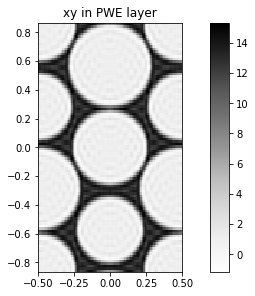

In [12]:
# Pick some starting point and show what the supercell is about
r_start = npa.array([0.45, 0.4, 0.5])
pwe = pwe_3hole(r_start)
pwe.plot_overview_ft()

In [24]:
# Run the optimization
(r_opt, ofs) = adam_optimize(of_bg, r_start, grad_test, step_size = 5e-4, Nsteps = 100, 
                             options = {'direction': 'max', 'disp': ['of', 'params']})

At iteration 0 :
Objective value is:   0.035416385643575965
Parameters are:       [ 0.4500  0.4000  0.5000]
At iteration 1 :
Objective value is:   0.03621979632227651
Parameters are:       [ 0.4505  0.4005  0.5005]
At iteration 2 :
Objective value is:   0.03702972788017156
Parameters are:       [ 0.4510  0.4010  0.5010]
At iteration 3 :
Objective value is:   0.03784611538383398
Parameters are:       [ 0.4515  0.4015  0.5015]
At iteration 4 :
Objective value is:   0.038668846801077184
Parameters are:       [ 0.4520  0.4020  0.5020]
At iteration 5 :
Objective value is:   0.03949775261630578
Parameters are:       [ 0.4525  0.4025  0.5025]
At iteration 6 :
Objective value is:   0.04033259337149775
Parameters are:       [ 0.4530  0.4030  0.5030]
At iteration 7 :
Objective value is:   0.04117304475905392
Parameters are:       [ 0.4535  0.4035  0.5035]
At iteration 8 :
Objective value is:   0.04201867987476354
Parameters are:       [ 0.4540  0.4040  0.5040]
At iteration 9 :
Objective value is

At iteration 76 :
Objective value is:   0.07644925788093443
Parameters are:       [ 0.4722  0.4369  0.5246]
At iteration 77 :
Objective value is:   0.07685050440216795
Parameters are:       [ 0.4724  0.4374  0.5247]
At iteration 78 :
Objective value is:   0.07725895974103103
Parameters are:       [ 0.4726  0.4379  0.5249]
At iteration 79 :
Objective value is:   0.07734951886303354
Parameters are:       [ 0.4728  0.4384  0.5251]
At iteration 80 :
Objective value is:   0.07786934597951556
Parameters are:       [ 0.4727  0.4389  0.5250]
At iteration 81 :
Objective value is:   0.07808470249019511
Parameters are:       [ 0.4726  0.4394  0.5248]
At iteration 82 :
Objective value is:   0.07826056161647432
Parameters are:       [ 0.4724  0.4399  0.5246]
At iteration 83 :
Objective value is:   0.07846267994943301
Parameters are:       [ 0.4723  0.4404  0.5245]
At iteration 84 :
Objective value is:   0.07868907546450654
Parameters are:       [ 0.4722  0.4410  0.5244]
At iteration 85 :
Objective 

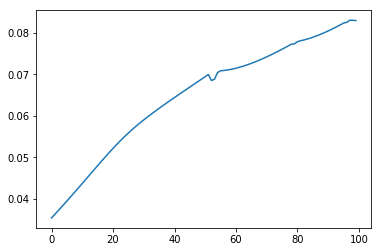

In [26]:
import matplotlib.pyplot as plt
plt.plot(ofs)
plt.show()

## Conclusion: 
- the starting structure is actually already really good (bg = 0.0907).
- the optimization here is approaching an unphysical structure cause the way things are defined right now holes shouldn't overlap...

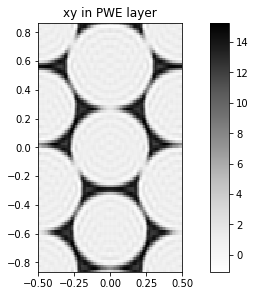

In [27]:
pwe = pwe_3hole(r_opt)
pwe.plot_overview_ft()